In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/ratzenboe/Documents/work/code/Chronos/')
from bayes_fitting.ChronosSkewedCauchy_bayes import ChronosSkewCauchyBayes

# Import data

In [3]:
data = pd.read_csv(
    # '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/edr3_mock_100pc-BG-Sept_21_2023.csv'
    '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/edr3_mock_200pc-XYZUVWVtLSR-labels-Sept_22_2022.csv'
)

In [4]:
random_subset_ids = np.random.choice(data.index, 100_000, replace=False)
data_subset = data.loc[random_subset_ids]

In [5]:
cbayes = ChronosSkewCauchyBayes(data=data_subset)

PARSEC isochrones read and processed!


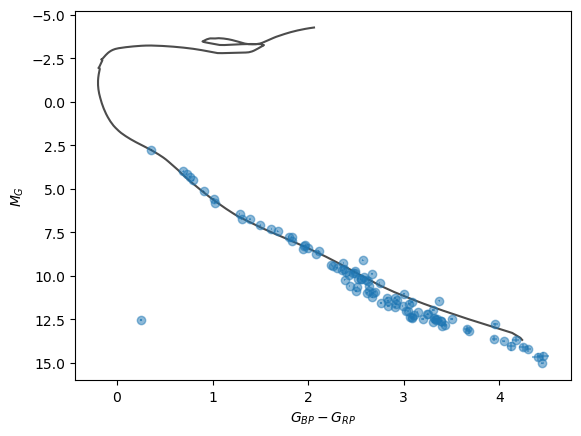

In [6]:
show_first_n = 100
X = cbayes.distance_handler.fit_data['hrd'][:show_first_n]
X_err = cbayes.distance_handler.fit_data['hrd_err'][:show_first_n]

# plt.scatter(*X.T)
plt.errorbar(*X.T, xerr=X_err[:,0], yerr=X_err[:,1], fmt='o', alpha=0.5)
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$M_G$')

isochrone = cbayes.isochrone_handler.model(logAge=np.log10(100*10**6), feh=0, A_V=0, g_rp=cbayes.use_grp)
plt.plot(*isochrone.T, c='k', alpha=0.7)

plt.gca().invert_yaxis()

In [7]:
# Stack isochone models
feh = 0
A_V = 0
isochrones = []
log_ages = []
for age_i in np.logspace(6, 9, 100):
    logAge = np.log10(age_i)
    iso_coords = cbayes.isochrone_handler.model(logAge, feh, A_V, g_rp=False)
    isochrones.append(iso_coords)
    log_ages.append(np.ones(len(iso_coords))*logAge)

In [8]:
isochrones_all = np.vstack(isochrones)
log_ages_all = np.hstack(log_ages)

In [9]:
# Prepare some data
show_first_n = -1
X = cbayes.distance_handler.fit_data['hrd'].copy()
X_err = cbayes.distance_handler.fit_data['hrd_err'].copy()
X_err_max = np.max(X_err, axis=1)
# 
color_factor = np.std(X, axis=0).max()/np.std(X, axis=0).min()
X[:,0] *= color_factor
isochrones_all[:,0] *= color_factor

# Scale color to magnitude range

In [10]:
# Nearest neighbors determine ages
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors().fit(isochrones_all)

neigh_dist, neigh_idx = nn.radius_neighbors(X, radius=X_err_max*5, return_distance=True, sort_results=True)

In [11]:
age_mean_sources = []
age_std_sources = []

for n_i in neigh_idx:
    if len(n_i) > 0:
        age_mean_sources.append(np.median(log_ages_all[n_i]))
        age_std_sources.append(np.std(log_ages_all[n_i]))
    else:
        age_mean_sources.append(np.nan)
        age_std_sources.append(np.nan)
    
    

In [12]:
age_mean_sources = np.array(age_mean_sources)
age_std_sources = np.array(age_std_sources)

In [13]:
not_nan = np.isnan(age_mean_sources)
print(not_nan.sum())

21631


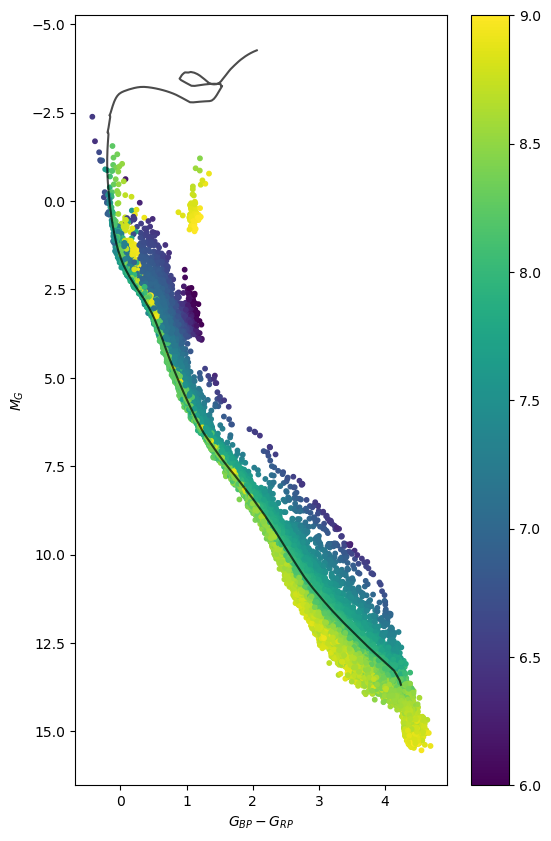

In [17]:
plt.figure(figsize=(6, 10))

plt.scatter(*cbayes.distance_handler.fit_data['hrd'].T, s=10, c=age_mean_sources, cmap='viridis')
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$M_G$')

isochrone = cbayes.isochrone_handler.model(logAge=8, feh=feh, A_V=A_V, g_rp=cbayes.use_grp)
plt.plot(*isochrone.T, c='k', alpha=0.7)

plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig('/Users/ratzenboe/Desktop/retreat/age_sources.png')

# GP model 

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [76]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler(feature_range=(-1, 1))

In [144]:
is_not_nan = ~np.isnan(age_mean_sources)

feature_space = ['X', 'Y', 'Z']
X_all = data_subset.loc[is_not_nan, feature_space].values
y_all_orig = age_mean_sources[is_not_nan]
y_all = y_all_orig.reshape(-1,1)
y_err = age_std_sources[is_not_nan].reshape(-1,1)

# X = x_scaler.fit_transform(X_all)
# y = y_scaler.fit_transform(y_all)

# Randomly split into train (80%) and test (20%) 
X_train, X_test, y_train, y_test, y_err_train, y_err_test = train_test_split(X_all, y_all, y_err, test_size=0.2, random_state=33)

In [145]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

In [146]:
y_train.min(), y_train.max()

(6.0, 9.0)

In [16]:
# kernel = 1.0 * RBF(length_scale=3.0, length_scale_bounds=(0.5, 20.0))
# 
# gp = GaussianProcessRegressor(alpha=y_err).fit(X_train, y_train)
# y_predict = gp.predict(X_train)

In [147]:
y_err_train**2

array([[0.06373737],
       [0.00910462],
       [0.        ],
       ...,
       [0.00194899],
       [0.00888372],
       [0.0272173 ]])

In [110]:
from sklearn.cluster import KMeans
from GPy.models import SparseGPRegression as SGPR
from GPy.mappings.constant import Constant
from GPy.kern import RBF

In [148]:
N, dim = X_train.shape
kernel = RBF(input_dim=dim, ARD=False)
mf = Constant(dim, 1, np.mean(y_train))

M = round(np.log(N)**dim)

In [149]:
ind_clstrs = KMeans(n_clusters=M).fit(X_train)
Z = ind_clstrs.cluster_centers_

 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [155]:
%%time
gp = SGPR(X_train, y_train, kernel=kernel, mean_function=mf, Z=Z, normalizer=True)

CPU times: user 36.5 s, sys: 17.2 s, total: 53.7 s
Wall time: 8.51 s


In [156]:
np.mean(y_err_train)

0.19761285566490416

In [157]:
gp.likelihood.variance = np.mean(y_err_train)

In [152]:
gp.optimize('bfgs', max_iters=100)

In [159]:
y_pred, y_var = gp.predict(X_train)

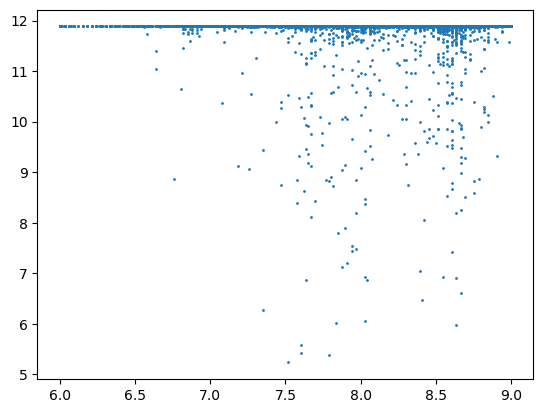

In [160]:
plt.scatter(y_train, y_pred, s=1);

In [27]:
sys.path.append('/Users/ratzenboe/Documents/work/code/DMGPE/')

In [30]:
from dmogpe import DeepMixtureGPE

In [102]:
m = DeepMixtureGPE(
    n_experts=6,
    sparse_gp=True, 
    fix_ind_pnts=True, 
    initial_clustering='GMM', 
    random_state=12
)

In [103]:
%%time
m.fit(X_train, y_train, mode='CCR', verbose=0)

 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


1968/1968 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Optimization restart 1/2, f = 27843.11530419864
Optimization restart 2/2, f = 27823.52048965829
No points were assigned to expert 1
No points were assigned to expert 2


 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Optimization restart 1/2, f = 28908.813507939565
Optimization restart 2/2, f = 28905.87544237231


 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Optimization restart 1/2, f = 30054.810791436998


 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/GPy/kern/src/stationary.py:358: RuntimeWarning:invalid value encountered in divide


Optimization restart 2/2, f = 30043.73612524369


 /Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Optimization restart 1/2, f = 2443.5800311895555
Optimization restart 2/2, f = 2437.7364032432615
CPU times: user 1h 15min 5s, sys: 1h 6min 29s, total: 2h 21min 35s
Wall time: 15min 36s


In [104]:
len(m.gp_experts)

4

In [101]:
y_pred, y_var = m.hard_prediction(X_train, return_variance=True)

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step


IndexError: list index out of range

In [64]:
# y_pred += y_all_mean

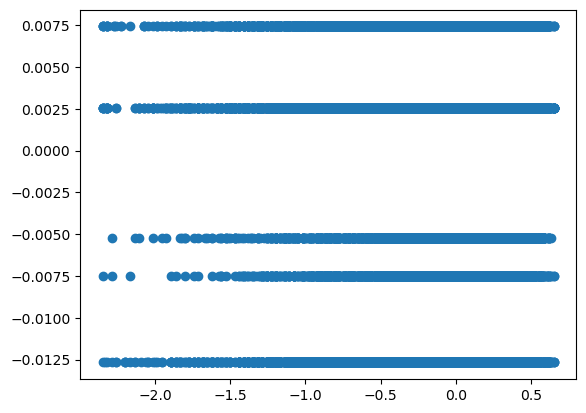

In [66]:
plt.scatter(y_train, y_pred)